In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle

%matplotlib inline

In [2]:
reg_data = pd.read_csv('final_players.csv')

In [3]:
reg_data.head()

,full_name,age,league,season,position,current_club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,...,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,weekly_wages,market_value
0,De Gea,29,Premier League,2018/2019,Goalkeeper,Manchester United,3420,1710,1710,Spain,...,90,3420,0,0.03,310,419,90,18,200000,56000000
1,Matteo Darmian,30,Premier League,2018/2019,Defender,Manchester United,443,353,90,Italy,...,74,0,0,0.00,411,366,102,25,36000,5500000
2,Victor Nilsson Lindelöf,25,Premier League,2018/2019,Defender,Manchester United,2602,1112,1490,Sweden,...,87,2602,2602,0.03,263,249,88,14,97000,22000000
3,Luke Shaw,24,Premier League,2018/2019,Defender,Manchester United,2592,1170,1422,England,...,89,236,648,0.38,262,104,79,13,90000,16500000
4,Eric Bertrand Bailly,25,Premier League,2018/2019,Defender,Manchester United,637,349,288,Côte d'Ivoire,...,53,319,0,0.28,340,271,142,26,100000,16500000


####  USING DOMAIN KNOWLEDGE FOR FEATURE SELECTION AND BUILD BASELINE MODEL

In [4]:
target = reg_data['weekly_wages']
predictors = reg_data[['age', 'assists_overall', 'penalty_goals', 'penalty_misses', 
               'minutes_played_overall','market_value', 'clean_sheets_overall']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 42, test_size = 0.30)

In [6]:
ss = StandardScaler()
X_train_scaled  = ss.fit_transform(X_train)

In [7]:
X_test_scaled = ss.transform(X_test)

In [8]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
print('Baseline model for Continuous variables')
print('Training r^2:', linreg.score(X_train_scaled, y_train))
print('Testing r^2:', linreg.score(X_test_scaled, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg.predict(X_train_scaled)))
print('Testing MSE:', mean_squared_error(y_test, linreg.predict(X_test_scaled)))

Baseline model for Continuous variables
Training r^2: 0.67336666045365
Testing r^2: 0.6441085449289107
Training MSE: 479954644.88109446
Testing MSE: 508515576.75408506


The above model is performing averagely but take into account we haven't added the categorical variables and the difference in MSE between training and the test is not a lot so the model points more towards underfitting than overfitting.

Applying log-transform before scaling the features but first things first we check for the normality of the distribution of the features

In [10]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

In [11]:
log_X_train_scaled = ss.fit_transform(X_train_log)
log_X_test_scaled = ss.transform(X_test_log)

In [12]:
linreg_2 = LinearRegression()
linreg_2.fit(log_X_train_scaled, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
print('Baseline model for Continuous variables')
print('Training r^2:', linreg_2.score(log_X_train_scaled, y_train))
print('Testing r^2:', linreg_2.score(log_X_test_scaled, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_2.predict(log_X_train_scaled)))
print('Testing MSE:', mean_squared_error(y_test, linreg_2.predict(log_X_test_scaled)))

Baseline model for Continuous variables
Training r^2: 0.3510315129418742
Testing r^2: 0.36215117177233347
Training MSE: 953593531.442938
Testing MSE: 911390425.778329


With the log transformations of the features, the model gets worse as the proportion of varaince explained by the model decreases when compared to the first model

The next step is to add the categorical variables, the league and the position of each player into the model features

In [14]:
# using One Hot Encoder
cat_predictors = reg_data[['league', 'position']]
X_train_cat, X_test_cat, y_train, y_test = train_test_split(cat_predictors, target, test_size = 0.30, random_state = 42)

In [15]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cat)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [16]:
X_train_ohe = ohe.transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

In [17]:
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)
X_train_all = pd.concat([pd.DataFrame(X_train_scaled), cat_train_df], axis = 1)
X_test_all = pd.concat([pd.DataFrame(X_test_scaled), cat_test_df], axis = 1)
linreg_all = LinearRegression()
linreg_all.fit(X_train_all, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
print('Baseline model Continuous and Categorical')
print('Training r^2:', linreg_all.score(X_train_all, y_train))
print('Testing r^2:', linreg_all.score(X_test_all, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_all.predict(X_train_all)))
print('Testing MSE:', mean_squared_error(y_test, linreg_all.predict(X_test_all)))
    

Baseline model Continuous and Categorical
Training r^2: 0.6885733234410595
Testing r^2: 0.6724766647520386
Training MSE: 457609992.176367
Testing MSE: 467981783.07138664


with the adding of categorical variables, the R-squared of the training and test data improved and the MSE also decreased and so did the difference in the Training and the testing model MSE. which means this model is more generalizable and more robust than the previous two models

### POLYNOMIAL REGRESSION


Accounting for interactions in a model is quite important, what you are essentially doing is transforming a variable role in a linear regression based on another one, using PolyNomial features allows both interactions and polynomial expansions.

In [19]:
poly_features = PolynomialFeatures(2)
  
  # transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train_scaled)

# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)

# predicting on test data-set
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test_scaled))



Polynomial expansion systematically provides automatic means of creating both interactions and non-linear power transformations of the original variables.


In [20]:
# evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)

# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)


print("\n")

print(" Polynomial training set for continuous")

print("MSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

print("\n")

print("Polynomial test set for continuous")

print("MSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

print("\n")





 Polynomial training set for continuous
MSE of training set is 19773.982259392626
R2 score of training set is 0.7338977219035463


Polynomial test set for continuous
MSE of test set is 20622.378317273862
R2 score of test set is 0.7023603401791982




We are able to get an improved R-squared of 0.702 for the test set, but the main question is does the model overfit? The difference between the RMSE of both training set predictions and test set predictions is not that high. So at the moment the model does not overfit to the training data.

In [21]:
poly_features = PolynomialFeatures(2)
  
  # transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train_all)

# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)

# predicting on test data-set
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test_all))
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)

# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)


print("\n")

print(" Polynomial training set for continuous and categorical")

print("MSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

print("\n")

print("Polynomial test set for continuous and categorical ")

print("MSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

print("\n")






 Polynomial training set for continuous and categorical
MSE of training set is 17300.084685664737
R2 score of training set is 0.7963160679576795


Polynomial test set for continuous and categorical 
MSE of test set is 19779.01250959649
R2 score of test set is 0.7262068928872164




The result above constitutes the best prediction at r-squared = 0.72 for the test set with both continuous and categorical features taken into account

The next thing to test out is whether interactions between two features can get a better predicting model than the baseline model

In [22]:
from itertools import combinations
combinations = list(combinations(X_train.columns, 2))
interactions = []
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg,predictors, target, scoring='r2', cv=crossvalidation))

data = X_train.copy()
for comb in combinations:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(linreg, data, y_train, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score,3)))
            
print('Top interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:20])

Top interactions: [('age', 'market_value', 0.692), ('age', 'assists_overall', 0.662)]


As it turns out, multiplying age and market value as one predictor variable will give a better predicting model of 0.692

Running a cross validation on the train polynomial fitted data

In [23]:
lm = LinearRegression()

scores = cross_val_score(lm, X_train_poly, y_train, cv=10, scoring='r2')
mse_scores = cross_val_score(lm, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error')

print('Cross Validation Mean r2:',np.mean(scores))
print('Cross Validation Mean MSE:',np.mean(mse_scores))
print('Cross Validation 10 Fold Score:',scores)
print ('Cross Validation 10 Fold mean squared error',-(mse_scores) )


Cross Validation Mean r2: -1.3961612169908437e+19
Cross Validation Mean MSE: -3.717660535344389e+28
Cross Validation 10 Fold Score: [ 5.36122899e-01  7.10239682e-01  6.47703873e-01  6.99841520e-01
  7.46730447e-01 -1.39616122e+20  7.10631993e-01  4.72138545e-01
  8.28664951e-01  6.44435068e-01]
Cross Validation 10 Fold mean squared error [3.32116214e+08 3.18903548e+08 2.77901354e+08 5.09916868e+08
 3.54793675e+08 3.71766054e+29 2.51313166e+08 4.21364558e+08
 5.37120488e+08 5.14131125e+08]


Cross validation mean for the poly model is 0.658

### RIDGE AND LASSO REGULARIZATION TECHNIQUES

In [24]:
lasso = Lasso(alpha=0.2) #Lasso is also known as the L1 norm.
lasso.fit(X_train_all, y_train)
print( 'Lasso')
print('Training r^2:', lasso.score(X_train_all, y_train))
print('Testing r^2:', lasso.score(X_test_all, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train_all)))
print('Testing MSE:', mean_squared_error(y_test, lasso.predict(X_test_all)))

print("\n")
    
ridge = Ridge(alpha = 0.2) #Ridge is also known as the L2 norm.
ridge.fit(X_train_all, y_train)
print('Ridge')
print('Training r^2:', ridge.score(X_train_all, y_train))
print('Testing r^2:', ridge.score(X_test_all, y_test))
print('Training MSE:', mean_squared_error(y_train, ridge.predict(X_train_all)))
print('Testing MSE:', mean_squared_error(y_test, ridge.predict(X_test_all)))

Lasso
Training r^2: 0.6885733204674268
Testing r^2: 0.6724757368979337
Training MSE: 457609996.54581934
Testing MSE: 467983108.83590996


Ridge
Training r^2: 0.6885733097449265
Testing r^2: 0.6724810119135127
Training MSE: 457610012.30144894
Testing MSE: 467975571.628845


Note that the Ridge and Lasso Regqularization is used whne avoiding the problem of model complexity a sthe model won't learn from general rules but will just be memeorizing the dataset itself.
The lasso regularization technique does a good job of feature selection and parameter shrinkage whilst ridge only shrinks coefficients of parameters

our best model so far is the PolyRegression model, we are going to loop through a Poly features of 10 degrees to see which gives the lowest RMSE score and the best model based on all the predictors selected

Best degree 2 with RMSE 19781.8849302735


Text(0, 0.5, 'RMSE')

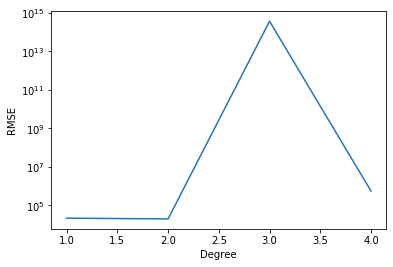

In [25]:
rmses = []
degrees = np.arange(1, 5)
min_rmse, min_deg = 1e10, 0
for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(X_train_all)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(X_test_all)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

Clearly the best Poly model is with 2 PolyNomial Features

### USING RIDGE AND LASSO REGULARIZATION TO REDUCE MODEL COMPLEXITY AND ELIMINATE MULTICOLLINEARITY 

In [26]:
lass_target = reg_data['weekly_wages']
lass_predictor = reg_data.drop(columns = ['weekly_wages', 'full_name','season', 'position', 'current_club',
                               'nationality','league' ])

In [27]:
lass_predictor.head()

,age,minutes_played_overall,minutes_played_home,minutes_played_away,appearances_overall,appearances_home,appearances_away,goals_overall,goals_home,goals_away,...,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,market_value
0,29,3420,1710,1710,38,19,19,0,0,0,...,67,90,3420,0,0.03,310,419,90,18,56000000
1,30,443,353,90,6,4,1,0,0,0,...,63,74,0,0,0.00,411,366,102,25,5500000
2,25,2602,1112,1490,30,12,17,1,1,0,...,68,87,2602,2602,0.03,263,249,88,14,22000000
3,24,2592,1170,1422,29,13,16,1,1,0,...,72,89,236,648,0.38,262,104,79,13,16500000
4,25,637,349,288,12,5,3,0,0,0,...,53,53,319,0,0.28,340,271,142,26,16500000


In [28]:
X_train_lass, X_test_lass, y_train_lass, y_test_lass = train_test_split(lass_predictor, lass_target, random_state = 42, test_size = 0.30)

In [29]:
X_train_lass = np.log(X_train_lass + 1)
X_test_lass = np.log(X_test_lass + 1)

In [30]:
lass_X_train_scaled = ss.fit_transform(X_train_lass)
lass_X_test_scaled = ss.transform(X_test_lass)

In [31]:
lass_X_train_all = pd.concat([pd.DataFrame(lass_X_train_scaled), cat_train_df], axis = 1)
lass_X_test_all = pd.concat([pd.DataFrame(lass_X_test_scaled), cat_test_df], axis = 1)

In [32]:
lasso = Lasso(alpha=0.2) #Lasso is also known as the L1 norm.
lasso.fit(lass_X_train_all, y_train_lass)
print( 'Lasso')
print('Training r^2:', lasso.score(lass_X_train_all, y_train_lass))
print('Testing r^2:', lasso.score(lass_X_test_all, y_test_lass))
print('Training MSE:', mean_squared_error(y_train_lass, lasso.predict(lass_X_train_all)))
print('Testing MSE:', mean_squared_error(y_test_lass, lasso.predict(lass_X_test_all)))

print("\n")
    
ridge = Ridge(alpha = 0.2) #Ridge is also known as the L2 norm.
ridge.fit(lass_X_train_all, y_train_lass)
print('Ridge')
print('Training r^2:', ridge.score(lass_X_train_all, y_train_lass))
print('Testing r^2:', ridge.score(lass_X_test_all, y_test_lass))
print('Training MSE:', mean_squared_error(y_train_lass, ridge.predict(lass_X_train_all)))
print('Testing MSE:', mean_squared_error(y_test_lass, ridge.predict(lass_X_test_all)))


Lasso
Training r^2: 0.42076149608872654
Testing r^2: 0.43668899386434934
Training MSE: 851132376.236633
Testing MSE: 804887043.7751181


Ridge
Training r^2: 0.4207957386004175
Testing r^2: 0.4364615610167731
Training MSE: 851082060.3302368
Testing MSE: 805212011.2448622


/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952026121668.4601, tolerance: 344574024.13646054
  positive)


With Ridge and Lasso doing both feature selection and paramter coefficient penalizing, the model performs worse than the earlier versions of it but these models also display the attribute of not overfitting and genearlizing to the test data. As more features were added, the Ridge and Lasso severely penalised the models and the MSE is also greater

#### USING SCI-KIT LEARN RECURSIVE FEATURE ELIMINATION METHOD

In [33]:
def run_model(model,X_train,X_test,y_train,y_test):
    
    print('Training R^2 :',model.score(X_train,y_train))
    y_pred_train = model.predict(X_train)
    print('Training Root Mean Square Error',np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
    print('\n----------------\n')
    print('Testing R^2 :',model.score(X_test,y_test))
    y_pred_test = model.predict(X_test)
    print('Testing Root Mean Square Error',np.sqrt(metrics.mean_squared_error(y_test,y_pred_test)))

In [34]:
rfe = RFECV(LinearRegression(),cv=5)
X_rfe_train = rfe.fit_transform(X_train_lass,y_train_lass)
X_rfe_test = rfe.transform(X_test_lass)
lm = LinearRegression().fit(X_rfe_train,y_train)
run_model(lm,X_rfe_train,X_rfe_test,y_train_lass,y_test_lass)
print ("The optimal number of features is: ",rfe.n_features_)

Training R^2 : 0.3832199693374999
Training Root Mean Square Error 30104.747989003252

----------------

Testing R^2 : 0.39045865164235266
Testing Root Mean Square Error 29511.74812688597
The optimal number of features is:  31


The RMSE massively reduces compared to the other regularisation models, the optimal number of features is 31 but the R-squared value is the worst amongst all built models.

### ENSEMBLE METHOD 

In [35]:
#using a decision tree regressor
regressor = DecisionTreeRegressor(random_state = 42)
regressor.fit(X_train_lass, y_train_lass)
print('The r-squared for DTR is :', r2_score(y_test_lass, regressor.predict(X_test_lass)))
print('The mean_squared_error for DTR is :', mean_squared_error(y_test_lass, regressor.predict(X_test_lass)))

The r-squared for DTR is : 0.30243926425606493
The mean_squared_error for DTR is : 996709796.7749062


In [36]:
regressor = DecisionTreeRegressor(random_state = 42)
regressor.fit(X_train_all, y_train)
print('The r-squared for DTR is :', r2_score(y_test, regressor.predict(X_test_all)))
print('The mean_squared_error for DTR is :', mean_squared_error(y_test_lass, regressor.predict(X_test_all)))

The r-squared for DTR is : 0.38745462156531796
The mean_squared_error for DTR is : 875235586.4811133


In [37]:
#using XGBOOST ensemble learner


In [38]:
xg_regressor = XGBRegressor(random_state=42)
xg_regressor.fit(X_train_lass, y_train_lass)

training_preds = xg_regressor.predict(X_train_lass)
test_preds = xg_regressor.predict(X_test_lass)

training_score = r2_score(y_train_lass, training_preds)
mean_squared_error_train = mean_squared_error (y_train_lass, training_preds)
test_score = r2_score(y_test_lass, test_preds)
mean_squared_error_test = mean_squared_error (y_test_lass, test_preds)

print('Training score: {:.2}'.format(training_score ))
print('mean_squared_error for train: {:.2}'.format(mean_squared_error_train))
print('Validation score: {:.2}'.format(test_score ))
print('mean_squared_error for test: {:.2}'.format(mean_squared_error_test))

[09:13:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Training score: 0.83
mean_squared_error for train: 2.5e+08
Validation score: 0.67
mean_squared_error for test: 4.7e+08


In [39]:
xg_regressor = XGBRegressor(random_state=42)
xg_regressor.fit(X_train_all, y_train)

training_preds = xg_regressor.predict(X_train_all)
test_preds = xg_regressor.predict(X_test_all)

training_score = r2_score(y_train, training_preds)
mean_squared_error_train = mean_squared_error (y_train, training_preds)
test_score = r2_score(y_test, test_preds)
mean_squared_error_test = mean_squared_error (y_test, test_preds)

print('Training score: {:.2}'.format(training_score ))
print('mean_squared_error for train: {:.2}'.format(mean_squared_error_train))
print('Validation score: {:.2}'.format(test_score ))
print('mean_squared_error for test: {:.2}'.format(mean_squared_error_test))

[09:13:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Training score: 0.83
mean_squared_error for train: 2.4e+08
Validation score: 0.73
mean_squared_error for test: 3.9e+08


This is the best training score yet on the dataset but the difference in the mean square error for the train and test data set means the model is overfitting to the training data and not genearlizing to new data

In [40]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01,.03, 0.05, .07], #so called `eta` value
              'max_depth': [2,3,4,5, 6,],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.15,0.25,0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

In [41]:
xgb_grid.fit(X_train_all.as_matrix(), y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished
/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05, 0.07],
                         'max_depth': [2, 3, 4, 5, 6], 'min_child_weight': [4],
                    

In [42]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7009692865838489
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.25}


In [44]:
xgb_train = xgb_grid.predict(X_train_all.as_matrix())
xgb_predictions = xgb_grid.predict(X_test_all.as_matrix())


training_score = r2_score(y_train, xgb_train)
mean_squared_error_train = mean_squared_error (y_train, xgb_train)

test_score = r2_score(y_test, xgb_predictions)
mean_squared_error_test = mean_squared_error (y_test, xgb_predictions)

print('Training score: {:.2}'.format(training_score ))
print('mean_squared_error for train: {:.2}'.format(mean_squared_error_train))
print('test score: {:.2}'.format(test_score ))
print('mean_squared_error for test: {:.2}'.format(mean_squared_error_test))

Training score: 0.83
mean_squared_error for train: 2.5e+08
test score: 0.76
mean_squared_error for test: 3.5e+08


/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/yusufolodo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


The model has  r-squared of 0.83 for the train set and 0.76 for test set and the mean squared error improved compared to the non-hyperparamter tuned model.

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
data = cosine_similarity(X_train_all)

In [47]:
type(data)

numpy.ndarray

In [48]:
df = pd.DataFrame(data = data[0:, 0:], 
                 index = [i for i in range(data.shape[0])],
                  columns = ['f' + str(i) for i in range(data.shape[1])])
df.head(25)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f2335,f2336,f2337,f2338,f2339,f2340,f2341,f2342,f2343,f2344
0,1.000000,-0.091952,-0.228092,0.618863,0.095940,-0.452772,0.404534,-0.203345,-0.046381,0.096728,...,0.931204,0.811829,-0.028316,-0.347458,-0.111570,-0.217924,0.437466,-0.034023,0.719556,0.329240
1,-0.091952,1.000000,0.536741,0.241940,0.295111,-0.055307,0.244672,-0.246842,0.233113,0.205742,...,-0.131102,-0.058291,-0.050034,0.232764,-0.414572,0.288268,0.419675,-0.066852,0.115123,0.120528
2,-0.228092,0.536741,1.000000,-0.107603,0.595426,0.036437,-0.086371,-0.232557,-0.043840,0.142447,...,-0.244392,-0.325503,0.208724,0.162139,-0.465973,0.783573,0.402496,-0.495655,0.028516,0.349114
3,0.618863,0.241940,-0.107603,1.000000,0.114722,-0.382983,0.621728,-0.426925,-0.101264,0.156987,...,0.572217,0.700180,-0.351481,-0.242431,-0.331505,-0.245441,0.640243,-0.098366,0.584549,0.308257
4,0.095940,0.295111,0.595426,0.114722,1.000000,-0.130959,-0.070642,-0.183933,-0.155248,0.333976,...,0.074299,0.177520,-0.005235,-0.028086,-0.546721,0.678323,0.512035,-0.577655,0.334680,0.718015
5,-0.452772,-0.055307,0.036437,-0.382983,-0.130959,1.000000,-0.434480,0.484009,0.147593,0.173007,...,-0.219138,-0.443589,0.009969,0.482159,0.545274,-0.032354,-0.476168,0.161888,-0.504275,-0.119813
6,0.404534,0.244672,-0.086371,0.621728,-0.070642,-0.434480,1.000000,-0.289321,-0.051074,0.090265,...,0.253142,0.429103,0.014655,-0.345535,-0.167917,-0.318172,0.414641,0.307558,0.295356,0.014585
7,-0.203345,-0.246842,-0.232557,-0.426925,-0.183933,0.484009,-0.289321,1.000000,0.145294,-0.379738,...,-0.056494,-0.154971,0.078791,0.450788,0.813208,-0.070878,-0.436717,0.303382,-0.290524,-0.251623
8,-0.046381,0.233113,-0.043840,-0.101264,-0.155248,0.147593,-0.051074,0.145294,1.000000,0.183684,...,-0.101818,0.036631,-0.090484,0.635226,-0.005188,-0.088938,-0.015307,0.621802,0.298274,-0.324754
9,0.096728,0.205742,0.142447,0.156987,0.333976,0.173007,0.090265,-0.379738,0.183684,1.000000,...,0.065208,0.163637,-0.070326,-0.034603,-0.208769,-0.049495,0.112326,0.046470,0.142126,0.532926


In [49]:
X_train.head(25)

,age,assists_overall,penalty_goals,penalty_misses,minutes_played_overall,market_value,clean_sheets_overall
2238,21,1,0,0,245,5000000,0
2930,28,0,0,0,1440,775000,5
2723,37,0,0,0,1720,475000,1
1798,20,0,0,0,91,1100000,1
123,32,0,0,0,553,500000,1
1483,29,0,0,0,3060,27000000,9
1263,22,2,0,0,1003,1200000,3
220,28,3,0,0,1058,23000000,12
819,25,0,0,0,2017,700000,9
3249,25,0,0,0,1890,3000000,3


In [50]:
(reg_data.loc[[2238]])

,full_name,age,league,season,position,current_club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,...,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,weekly_wages,market_value
2238,Dennis Geiger,21,Bundesliga,2018/2019,Midfielder,Hoffenheim,245,124,121,Germany,...,61,245,245,0.37,0,0,0,15,17000,5000000


In [51]:
reg_data.loc[[1798]]

,full_name,age,league,season,position,current_club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,...,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,weekly_wages,market_value
1798,Thomas Basila,20,Ligue 1,2018/2019,Defender,Nantes,91,91,0,France,...,46,0,0,0.0,0,0,0,24,4000,1100000
